# Memory managment in OpenCL

In previous lessons we have looked at straightforward ways in which memory was allocated on the host and then copied to the device for use as global memory by the kernel. In the introduction we briefly covered the five different memory spaces that are accessible to an OpenCL Program.

* Host memory
* Global memory
* Local (shared) memory
* Private memory
* Constant memory

**Host memory** is usually the largest memory space on the host, and **global memory** is the largest and slowest memory space available on the compute device. **Local** and **Constant** memory is usually located in the small and fast caches on the compute device. **Private memory** is usually located in the registers, which are normally the fastest and smallest memory spaces available on the compute device. A programmer has some degree of control over where memory is stored during the operation of an OpenCL program. The diagram below shows what memory is available for access by both host and kernel threads (work-items) at runtime. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads.</figcaption>
</figure>

Kernel threads (work-items) can access *global*, *constant*, *local* and *private* memory, whereas host threads can only access *host* and *global* memory. Private memory for a kernel thread is exclusive to the kernel, meaning that no other kernel can access the same private memory. Local memory is accessible to all kernel threads in a workgroup, but not to kernel threads from another workgroup. *Global* and *Constant* memory is accessible from all kernel threads.

## Memory access from the host

From the introduction we know that Buffers are allocated on the host and they are migrated in and out of the compute device when they are needed. Here are some ways we can create Buffers and transfer memory in and out of them. 

### Buffer creation

Thus far we have been creating Buffers with the [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html) function using the **CL_MEM_READ_WRITE** memory flag. For example, this code creates a Buffer that has read-write access from the kernel, but no additional functionality.

```C++
    cl_mem buffer_C = clCreateBuffer(context, 
                                     CL_MEM_READ_WRITE, 
                                     nbytes_C, 
                                     NULL, 
                                     &errcode);
```

#### IO permission flags

We can choose other IO flags to let the OpenCL implementation how the Buffer is to be used. This may unlock additional optimisations depending on the OpenCL implementation.

| **Allocation flag** | **Functionality** | 
| :- | :- | 
|CL_MEM_READ_WRITE| Read-write access from a kernel | 
|CL_MEM_WRITE_ONLY| Write-only access from a kernel | 
|CL_MEM_READ_ONLY | Read-only access from a kernel | 
|CL_MEM_HOST_WRITE_ONLY | Write-only access from the host | 
|CL_MEM_HOST_READ_ONLY | Read-only access from the host | 
|CL_MEM_HOST_NO_ACCESS | No access from the host | 

Common-sense rules apply in the use of these flags. For example **CL_MEM_WRITE_ONLY** is incompatible with **CL_MEM_READ_WRITE**, and behaviour is undefined if one tries to write to a buffer that has been set as **CL_MEM_READ_ONLY**.

#### Using host memory

In addition to IO permission flags, there are flags that determine how memory is allocated in a Buffer.

| **Allocation flag** | **Functionality** | 
| :- | :- | 
|CL_MEM_USE_HOST_PTR | Use host memory as backing store for the buffer | 
|CL_MEM_ALLOC_HOST_PTR | Allocate pinned memory and use that as the backing store for the buffer | 
|CL_MEM_COPY_HOST_PTR | Copy from host memory during creation of a buffer | 
|CL_MEM_USE_PERISTENT_MEM_AMD | AMD-specific, create a zero-copy buffer that resides on the device |

The flag **CL_MEM_USE_HOST_PTR** allows the Buffer to use host memory as the backing store for a Buffer. One must make sure that there is enough host memory allocated to cover the memory used by the buffer and that the host memory is not de-allocated while the buffer is using it. OpenCL implementations are free to allocate caches on the compute device for temporary usage and then synchronize as required. Memory synchronization can be explicitly done using **mapping**, which will be discussed shortly. 

> I personally would **refrain** from using **CL_MEM_USE_HOST_PTR** for buffer allocations unless special care is taken with how the memory allocation is aligned. The memory has to be specifically aligned to the type of memory access. For example you are accessing memory as **float8** vector elements, then the memory must be aligned to a (8x4=32) byte boundary. OpenCL buffers that don't use **CL_MEM_USE_HOST_PTR** are aligned properly by default. During creation of this course I found this out the hard way. Usage of **CL_MEM_USE_HOST_PTR** with unaligned memory that was used as **float8** resulted in a random segfault - a bug that is **notoriously hard to fix**. Allocation of aligned memory for use in OpenCL buffers via **CL_MEM_USE_HOST_PTR** may be safely conducted using something like the helper function **h_alloc**, which uses the C11 function **aligned_alloc** to allocate memory that is aligned to the largest OpenCL datatype **cl_long16**.

Similarly, the flag **CL_MEM_COPY_HOST_PTR** creates an OpenCL buffer but copies memory from a host pointer during buffer creation. After the copy finishes, the host pointer is then available for use.  

Both **CL_MEM_USE_HOST_PTR** and **CL_MEM_COPY_HOST_PTR** require a host pointer to be passed into the call to [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html).

In the source code of [mat_mult_local.cpp](mat_mult_local.cpp) we create an OpenCL Buffer **A_d** by copying from **A_h** with the **CL_MEM_COPY_HOST_PTR** flag. 

```C++
    // Make buffer_A using array_A as the backing store
    // Make A_d by copying from A_h
    cl_mem A_d = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_COPY_HOST_PTR, 
        nbytes_A, 
        (void*)A_h, 
        &errcode
    );
    H_ERRCHK(errcode);
```
#### Creating buffers with pinned memory for fast IO

Pinned memory is host memory that cannot be paged out to swap. It enables fast and efficient Direct Memory Access (DMA) transfers from the host, however for OS health reasons the amount of pinned memory is usually limited to a fraction of the available memory. The flag **CL_MEM_ALLOC_HOST_PTR** passed in during buffer creation allocates pinned memory on the host as the backing store for the OpenCL buffer. In [mat_mult_local.cpp](mat_mult_local.cpp) we create **C_d** from pinned host memory by adding the **CL_MEM_ALLOC_HOST_PTR** flag.

```C++
    // Allocate buffer C from pinned host memory
    cl_mem C_d = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_ALLOC_HOST_PTR, 
        nbytes_C, 
        NULL, 
        &errcode
    );
    H_ERRCHK(errcode);
```

Both **CL_MEM_COPY_HOST_PTR** and **CL_MEM_ALLOC_HOST_PTR** may be used together, but there doesn't appear to be a valid reason why this is useful. Only **CL_MEM_USE_HOST_PTR** and **CL_MEM_ALLOC_HOST_PTR** are mutually exclusive.

On AMD platforms the three **\*HOST_PTR** flags allocate buffers that reside on the host. If you specify **CL_MEM_USE_PERISTENT_MEM_AMD** during buffer creation, then it creates an on-device zero-copy buffer whose contents may be efficiently mapped back to the host.

#### Summary of memory allocation flags

| **Allocation flag** | **Functionality** | 
| :- | :- | 
|CL_MEM_USE_HOST_PTR | Use host memory as backing store for the buffer | 
|CL_MEM_ALLOC_HOST_PTR | Allocate pinned memory and use that as the backing store for the buffer | 
|CL_MEM_COPY_HOST_PTR | Copy from host memory during creation of a buffer | 
|CL_MEM_USE_PERISTENT_MEM_AMD | AMD-specific, create a zero-copy buffer that resides on the device |

### Explicit memory movement

The OpenCL 1.2 and earlier standards require explicit memory transfers between OpenCL buffer and host. You have the option of copying either **contiguous** or **rectangular** regions of allocated memory. By rectangular I mean that if the memory allocation is interpreted as **folded into a multidimensional array**, then a rectangular copy would copy a rectangular region of that array.

#### Contiguous copies

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/contiguous_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Contiguous memory copy.</figcaption>
</figure>

If you only need to copy contiguous chunks of memory, then [clEnqueueWriteBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueWriteBuffer.html) **writes to** the OpenCL buffer from host memory and [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) reads **from** a buffer to host memory. The function [clEnqueueCopyBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueCopyBuffer.html) performs a copy of contiguous memory between two OpenCL buffers **within the same OpenCL context**. All three options have the ability to specify a starting offset (in bytes) within the OpenCL buffer, and [clEnqueueCopyBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) has the additional capability to specify the offset for the destination buffer.

#### Rectangular copies

Sometimes a contiguous copy is not sufficient, such as when you need to copy rectangular boundary areas of a multi-dimensional array. The functions [clEnqueueWriteBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueWriteBufferRect.html) **writes** a 3D rectangular region to the OpenCL buffer from host memory and [clEnqueueReadBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBufferRect.html) **reads** a 3D rectangular region from host memory. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/rectangular_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Rectangular memory copy.</figcaption>
</figure>

I found the documentation on these functions quite confusing to comprehend, particularly in translating from one indexing system (i.e row-major) to another. It is important to remember that in the documentation the word **"row"**  is the dimension along which memory is contiguous. **Row pitch** is the number of bytes along a row of **the memory allocation**, and **slice pitch** is the number of bytes in a slice of **the memory allocation**. Within the memory allocation a **region** is selected for the copy, it is of size (nbytes along the row, nrows, nslices). If you are only doing a 2D copy then use a value of 1 for **nslices**. The copy can be located at an **origin** within the memory allocations, this has units of (offset in bytes along a row, row id, slice id). Row id and slice id's are indices starting at 0. 

Rectangular copies result in more efficient copies than enqueuing numerous calls to the contiguous memory copy functions to cover the same region. In similar fashion, the function  [clEnqueueCopyBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueCopyBufferRect.html) copies 3D rectangular regions between OpenCL buffers. In [mat_mult_local.cpp](mat_mult_local.cpp) we use a rectangular copy to copy memory from **B_h** to **B_d**.

```C++
    // Do a rectangular copy from host to memory in buffer_B
    
    // B is of size (N1_A, N1_C)
    // Offset is in bytes, row_id and slice_id are indices
    size_t offset=0, row_id=0, slice_id = 0;
    
    // Make up the origin for host and buffer
    const size_t buffer_origin[] = {offset, row_id, slice_id};
    const size_t host_origin[] = {offset, row_id, slice_id};
    
    // Length of a row (in bytes)
    size_t buffer_row_pitch = N1_C * sizeof(cl_float); 
    size_t host_row_pitch = buffer_row_pitch;
    
    // Number of bytes in a slice 
    size_t buffer_slice_pitch = N1_A * buffer_row_pitch;
    size_t host_slice_pitch = N1_A * host_row_pitch;        
        
    /// Size of the region to copy, of course we only copy 1 slice
    size_t nrows = N1_A, nslices = 1;
    const size_t region[] = {buffer_row_pitch, nrows, nslices};
     
    // Enqueue the rectangular copy
    H_ERRCHK(
        clEnqueueWriteBufferRect(
            command_queue,
            B_d,
            blocking,
            buffer_origin,
            host_origin,
            region,
            buffer_row_pitch,
            buffer_slice_pitch,
            host_row_pitch,
            host_slice_pitch,
            B_h,
            0,
            NULL,
            NULL
        )
    );
```


#### Buffer mapping

With the contiguous and rectangular copies there are two memory spaces in use, one for the OpenCL buffer and one for the host. It is possible to map (or make available) an OpenCL buffer to the host, thus avoiding the explicit memory transfer. This approach can be particularly beneficial when a CPU or integrated GPU is employed, as the memory for the buffer is already on the host and no actual transfer from the device is needed. Buffer mapping can be useful for GPU's as well. With buffer mapping the OpenCL implementation has the opportunity to optimise transfers and synchronisation between OpenCL buffer and host. The command [clEnqueueMapBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueMapBuffer.html) maps an OpenCL buffer into host memory. It uses the following mapping flags:

| **Mapping flag** | **Functionality** | 
| :- | :- | 
|CL_MAP_READ | The buffer is being mapped for reading | 
|CL_MAP_WRITE | The buffer is being mapped for writing | 
|CL_MAP_WRITE_INVALIDATE_REGION | The buffer is going to be written by the host soon and we don't need to care what is in it (potential source of optimisation).

When a buffer is mapped to the host, access to the buffer from an OpenCL kernel is considered to be undefined. The [clEnqueueUnmapMemObject](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueUnmapMemObject.html) function unmaps the memory from the host and makes it available to kernels again. In [mat_mult_local.cpp](mat_mult_local.cpp) we map **C_d** back to the host and make the memory available to the host as **C_h**. Then we write **C_h** to disk before unmapping **C_d**.

```C++
    // Map C_d back to the host so we can write it to disk
    cl_float* C_h = (cl_float*)clEnqueueMapBuffer(
        command_queue,
        C_d,
        CL_TRUE,
        CL_MAP_READ,
        0,
        nbytes_C,
        0,
        NULL,
        NULL,
        &errcode
    );
    H_ERRCHK(errcode);
    
    // Write C_h to disk
    h_write_binary(C_h, "array_C.dat", nbytes_C);
    
    // Unmap C_d so we can release it
    H_ERRCHK(
        clEnqueueUnmapMemObject(
            command_queue,
            C_d,
            (void*)C_h,
            0,
            NULL,
            NULL
        )
    );
```


#### Filling buffers

Sometimes you need to fill or initialise the contents of a buffer. The [clEnqueueFillBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueFillBuffer.html) command fills buffers with a user-defined pattern. We fill buffer **B_d** with ones using this code

```C++
    // Fill buffer B_d with ones as an example of clEnqueueFillBuffer
    cl_float one = 1.0;
    H_ERRCHK(
        clEnqueueFillBuffer(
            command_queue,
            B_d,
            &one,
            sizeof(cl_float),
            0,
            nbytes_B,
            0,
            NULL,
            NULL
        )
    );
```

## Memory control and access from kernels

Kernels have access to the following memory spaces:

* Global memory
* Local (shared) memory
* Private memory
* Constant memory

[This link](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/addressSpaceQualifiers.html) provides more information on the memory spaces. Variables defined in kernel sources can be (and sometimes must be) qualified as to which memory space they belong to. There is, however a myriad of rules to navigate, as we shall see below.

### Global address space

Allocations of memory in the **global address space** are qualified by an additional **\_\_global** or **global** qualifier in front of the variable type when it is declared (both in function preambles as well as in the function body). Both are valid and you don't need to put the **\_\_** in front of **global**. I'm just doing it here so Jupyter syntax highlighting picks up the qualifier. Pointers to buffer allocations passed in to kernels **always** need to have the **\_\_global** qualifier. We see this in the kernel definition for **mat_mult_local** in [kernels_mat_mult.c](kernels_mat_mult.c).

```C
// kernels_mat_mult.c source

// Matrix multiply kernel that uses local memory
__kernel void mat_mult_local (
                        __global float* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float* shared_A,
                        __local  float* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

It is interesting that for the memory allocations brought into the kernel we can use any number of pointer types to interpret the memory. For example we can change the pointer type for **A** and **B** to **float8\*** and interpret the input arrays as elements of type **float8**

```C
__kernel void mat_mult_local (
                        __global float8* A, 
                        __global float8* B, 
                        __global float* C,
                        __local  float8* shared_A,
                        __local  float8* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

Of course we need to ensure that we don't go off the end of the array, and that the number of floats allocated for the buffers being passed in is a multiple of eight. 

Variables in the global address space can also be declared **outside kernel functions** if the **\_\_opencl_c_program_scope_global_variables** macro is defined.

```C
// kernels_mat_mult.c source

// Example of a global variable
#ifdef __opencl_c_program_scope_global_variables
__global int a_g = 2; 
__global float b_g[2] = {2.0,1.0}; 
#endif

// standard matrix multiply kernel 
__kernel void mat_mult_local (__global float* A,... 
```

If **a_g** and **b_g** are defined, then the variables are available to every kernel that runs in the program on the compute device.

### Constant address space

The constant address space is usually located in a fast cache and is defined by the **\_\_constant** or **constant** address qualifer. This makes it ideal for storing small (~16-128 KB) allocations of memory that must be accessible to all kernels (coefficients for example). The **clinfo** command shows you how much constant memory is available on each device.

In the source file [kernels_mat_mult.c](kernels_mat_mult.c) we define a couple of variables in the constant memory space

```C
// Example of constant memory
__constant float pi = 3.1415;
__constant float coeffs[] = {1.0, -2.0, 1.0};
```

Then we can use the constant variable **pi** within the **mat_mult_local** kernel as follows:
```C
// Scratch variable whose allocation uses constant memory
float temp=0.0*pi; 
```

### Local address space

Memory in the **local** address space is local to the workgroup, meaning every work-item in the workgroup can access the memory, but work-items in another workgroup cannot. Local memory is specified with the **\_\_local** or **local** qualifier in front of the variable type at declaration (which happens either in a kernel function or in the kernel function preamble). Local memory is often backed by fast caches on the compute device and **might** provide a speed boost by virtue of being in close proximity (in terms of latency and bandwidth) to the processor cores. Having said that, devices and OpenCL implementations are very good at caching global memory to fast caches, so you may or may not see a performance boost by using local memory.

There are two ways to allocate local memory, **static** and **dynamic** allocation:

#### Static allocation of local memory

Static allocations of local memory happen within the body of the kernel function. For example, in the code [kernels_mat_mult.c](kernels_mat_mult.c) we allocate an array of 10 floats

```C++
    // kernels_mat_mult.c source
    // Make a local scratch array for demonstration purposes
    // (not actually used)
    __local float scratch[10];
```

Static allocations of local memory must happen in the outermost scope within the function, this means every work-item has to execute the allocation. Some implementations will not let you hide the allocation in a code block, and you also cannot allocate local memory within functions that are called from kernels.

#### Dynamic allocation of local memory

Local memory for a workgroup may also be dynamically reserved when the kernel is enqueued. Allocations to local memory are brought into a kernel as an argument with the **\_\_local** (or **local**) address qualifier, as can be seen with the **shared_B** local memory allocations in the **mat_mult_local** kernel, in [kernels_mat_mult.c](kernels_mat_mult.c).

```C++
// kernels_mat_mult.c source

__kernel void mat_mult_local (
                        __global float* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

The amount of local memory to allocated is specified at runtime by the [clSetKernelArg](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSetKernelArg.html) function. In the [mat_mult_local.cpp](mat_mult_local.cpp) sources we specify how much memory is to be allocated for **shared_B**. Notice that the last pointer argument is NULL, whereas it usually points to a buffer or variable.

```C++
    // mat_mult_local.cpp source

    // Set shared memory in argument 3 for shared_B
    // Local size is going to be (local_size[0], N1_A)
    H_ERRCHK(clSetKernelArg(kernel, 3, local_size[0]*N1_A*sizeof(cl_float), NULL ));
```


#### Example, matrix multiplication with local memory

There is an opportunity to employ local memory within the matrix multiplication example. A workgroup is of size **(L0, L1)**. Every work item in a row of a workgroup needs access to the same row of matrix A, and every column in the workgroup needs access to the same column of matrix B. If the workgroup prefetches these rows and columns into local fast caches, then there is potential to save time on fetches from global memory. Using the dynamic memory allocation method above we allocate a local memory space **shared_B** to store the columns of B that will be used by the workgroup. The local memory allocation is of size (L1, N1_A).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_local.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

We divide the local memory space into blocks of elements along dimension 1 so that every work-item can be responsible for filling a portion of the shared spaces. There are **L0** blocks (along dimension 1) to copy for **shared_B**. The kernel code for filling the shared memory is below.

```C++

    // kernels_mat_mult.c source

    // start and end
    size_t start, end;
    
    // Fill shared_B
    
    // Get the start and end lengths
    get_start_end(L0, N1_A, s0, &start, &end);
    // Fill the columns of shared with B
    if (i1<N1_C) {
        for (size_t n=start; n<end; n++) {
            shared_B[s1*N1_A+n]=B[i1+n*N1_C]; 
        }
    }
    
    // Enqueue a local barrier to make sure all the work items finish
    barrier(CLK_LOCAL_MEM_FENCE);
```

We use a kernel function called **get_start_end** to get the start and end indices of a block along dimension 1 of shared memory. Then we use a loop to fill the **shared_B** from matrix B on the device. 

##### **Work item synchronisation**

Some work items will finish the copy before others, however they need to **wait** until that all work items have finished the copy before local memory allocations become useful. A call to the inbuilt OpenCL kernel function **barrier** with the **CLK_LOCAL_MEM_FENCE** ensures that local memory is consistent amongst the workgroup before proceeding.

```C++

    // kernels_mat_mult.c source
    
    // Enqueue a local barrier to make sure shared memory is filled
    barrier(CLK_LOCAL_MEM_FENCE);
```

If you also need to ensure global memory is consistent at a barrier within a workgroup you can use the **CLK_GLOBAL_MEM_FENCE** flag with the **barrier** call.

> The absence of a barrier is often a source of bugs. The work-items executed on GPU's operate in lock-step, so consistency between work-items and local memory is less of an issue. On CPU's however, the work items are more independent, therefore a barrier is **critical** to maintaining consistency when working with local memory.

After the barrier, **shared_B** is now populated and available for all work-items. While performing the matrix operation we draw from the local memory allocations instead of global memory 

```C++
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            // shared_B is of size (L1, N1_A)
            // C is of size (N0_C, N1_C)
            
            // Loop across row i0 of A
            // and across row s1 of shared_B
            temp+=A[i0*N1_A+n]*shared_B[s1*N1_A+n]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
```

The matrix multiplication code in [mat_mult_local.cpp](mat_mult_local.cpp) is using the local memory implementation. Feel free to run the example again to verify that it works!

##### **Running the application**

In [3]:
!make mat_mult_local.exe; ./mat_mult_local.exe

make: 'mat_mult_local.exe' is up to date.
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6226 MB
	    max buffer size: 1556 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Maximum error (infinity norm) is: 1.14441e-05


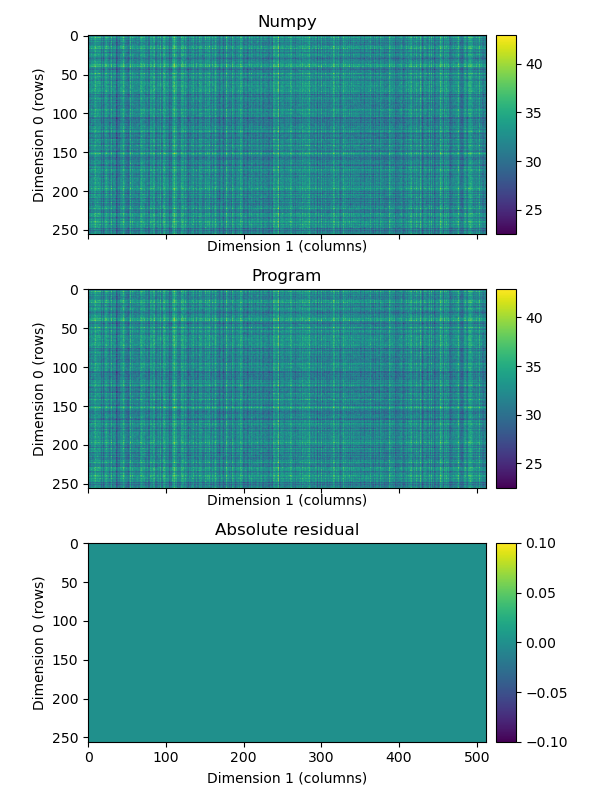

In [5]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A=defines["NCOLS_A"]
NROWS_C=defines["NROWS_C"]
NCOLS_C=defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.load_data()
mat_mul.check_data()

### Private memory

Private memory is the default storage space for variables created inside a running kernel. This memory is only available to the work item that allocates it. One does not need to use the **__private** (or **private**) qualifier as variables created in kernels are **private** by default. For example, in the **mat_mult** kernel in [kernels_mat_mult.c](kernels_mat_mult.c) we declare a private variable **temp** for use in the matrix dot products.

```C++
    // Scratch variable whose allocation uses constant memory pi
    float temp=0.0*pi;
```

Private memory is usually allocated from the fastest register memory on the device, but the  amount of available register memory is very small. If a kernel uses more register memory than there are variables, then register memory can spill over into global memory at the cost of performance.



### Generic addresses

Generic address spaces is an OpenCL 2.0 feature that enables functions called from kernels to accept pointer arguments from private, local, and global address spaces without having to qualify the address space they come from. Generic addresses are become available if the OpenCL implementation is 2.0+ compliant and the compiler option **"-cl-std=CL2.0"** is added to the compiler options at program compilation. Then, the following macro should be defined by the preprocessor.

```C++
__opencl_c_generic_address_space
```

## OpenCL vectors

In addition to the standard types, the OpenCL standard also defines a number of vector types with **n** = 2,3,4,8, and 16 elements. Vectors can unlock performance within an OpenCL application because memory is loaded into caches using cache lines that are typically around 64-128 bytes (or 16-32 floats) wide. Furthermore, CPU's have SIMD units that can process, in one instruction, vectors of floats to 64 bytes long. Here are the vector types as used in both host and kernel code.

| kernel C type | OpenCL standard type | Description and bits used |  
| :- | :- | :- |
| char**n** | cl_char**n** | **n** x 8 bits, signed two's complement integers  |
| uchar**n** | cl_uchar**n** | **n** x 8 bits, unsigned integers |
| short**n** | cl_short**n** | **n** x 16 bits, signed two's complement integers |
| ushort**n** | cl_ushort**n** | **n** x 16 bits, unsigned integers |
| int**n** | cl_int**n** | **n** x 32 bits, signed two's complement integers |
| uint**n** | cl_uint**n** | **n** x 32 bits, unsigned integers |
| long**n** | cl_long**n** | **n** x 64 bits, signed two's complement integers |
| ulong**n** | cl_ulong**n** | **n** x 64 bits, unsigned integers |
| float**n** | cl_float**n** | **n** x 32 bits, floating point numbers |
| double**n** | cl_double**n** | **n** x 64 bits, floating point numbers |

### Complex numbers in OpenCL

Complex numbers are not implemented in OpenCL, however you can store the real and imaginary components in a **float2** or **double2** vector type for example. One must manually perform the complex math on the individual components.

### Vector access from the host

There is a sophisticated means of indexing into a vector type within an OpenCL kernel, however from the host one has to use the **.s[index]** indexing to get at individual elements.

```C++
// Code from the host

// Declare an initialised vector
cl_float4 f = (cl_float4){0.0, 1.0, 2.0, 3.0};
    
// Could have also been done like this
//cl_float4 f = (cl_float4){0.0};

// Print out the last element
std::printf("%f\n", f.s[3]);
    
// Store a value in the last element
f.s[3] = 10.0;
    
// Print out the last element again
std::printf("%f\n", f.s[3]);
```

### Vector access from within a kernel

Allocations of memory that are passed to a kernel in the **\_\_global** or **\_\_local** address spaces can be interpreted as a vector data type. For example in this kernel definition we interpret the global memory allocations **A_star**, **BT_star** and the local memory allocations **shared_A_star** and **shared_BT_star** as vectors of type **float8**. 

```C++
__kernel void mat_mult_local_transp_vec (
                        __global float8* A_star, 
                        __global float8* BT_star, 
                        __global float* C,
                        __local  float8* shared_A_star,
                        __local  float8* shared_BT_star,
                        unsigned int N1_A_v, 
                        unsigned int N0_C,
                        unsigned int N1_C) {
```

One must make sure of two things when using memory in this way:

* The memory allocation is big enough so that the last element in the last vector accessed is backed by memory.
* The memory is byte-aligned so that the starting address of the allocation is a multiple of the vector length.

If an OpenCL function is performing the memory allocation, such as [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html) or [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) then it will usually allocate memory according to the largest OpenCL memory type (**long16**). Otherwise, use the C11 function **aligned_alloc** to allocate memory with the same alignment as there are bytes in the vector type. The helper function **h_alloc** in <a href="../include/cl_helper.hpp">cl_helper.hpp</a> allocates memory using the size of **cl_long16** as the alignment.

Access to a vector type from within a kernel is done using dot notation. You can use **.x .y .z** and **.w** for the first four elements, or you can use **.s0, .s1, .s2, .s3, .s4, .s5, .s6, .s7, .s8, .s9, .sa, .sb, .sc, .sd, .se, .sf** to access values up to the 16th element. A neat thing about OpenCL vectors is that you can "swizzle", or permute indices (using either .xyzw or .s* but not both) to mix up the order of the vector.

```C++
// Code within a kernel

// Explicit declaration
float4 f = (float4)(1.0f, 2.0f, 3.0f, 4.0f);

// Explicit declaration
float4 v = (float4)(1.0f);

// Access to element 0 (both expressions are equivalent)
v.x = 1.0f;
v.s0 = 1.0f;

// Valid examples of swizzling
v.xyzw = f.wzyx;
v.xyzw = f.s3210;
```

You can also load and store vectors from a memory allocation using the **vloadn** and **vstoren** functions. 

```C++
// OpenCL kernel code

// Assuming arr is a memory allocation from global memory

// Load a float4 vector starting at the
// memory location of offset*4 relative to arr
float4 f = vloadn(offset, arr);

// Store a float4 vector starting at the 
// memory location of offset*4 relative to arr
vstore4(f, offset, arr);
```

In order to avoid undefined behaviour, the address **arr** for the allocation needs to be byte-aligned to the data type being used. So as long as you use the allocated (and aligned) address as the address for **vstoren** and **vloadn** functions you will be fine.

### Example, using vectors for matrix multiplication

In this example we'd like to extend the local memory matrix multiplication solution to interpret the allocated buffers of matrices A and B as vectors of type **float8**. This means that loads and stores will happen 8 floats at a time. Here is the current local memory solution for matrix multiplication.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shmem.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

We would like to interpret each row in A and B as a row of vectors of **float8**. During the multiplication it is going to be difficult to work with vector elements down the columns of B, however to make memory access easier we enqueue a kernel to transpose **B** to make **BT**. Now memory access is along the rows of each input matrix.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shmem_transp.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication with a transpose.</figcaption>
</figure>

In this example the length **N1_A** is a multiple of 8, however it may not always be a multiple of 8, so we make two buffers **A_star** and **BT_star** whose length along dimension 1 is always a multiple of the vector length. We fill these arrays with zeros and then use rectangular copies to fill **A_star** and **BT_star** from **A** and **BT** (B-transposed).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_bt_star_fill.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Padding matrix BT to make BT* using a rectangular copy.</figcaption>
</figure>

Code for the buffer fill and rectangular copies is in [mat_mult_transpose_vector.cpp](mat_mult_transpose_vector.cpp) and we must ensure that we also enlarge the size of the local memory being allocated. In the kernel **mat_mult_local_transp_vec** in [kernels_mat_mult.c](kernels_mat_mult.c) we bring in the memory allocations as arrays of type **float8**. The variable **N1_A_v** is N1_A* divided by the vector length.

```C++
// kernels_mat_mult.c:109

// Local memory matrix multiply kernel
// where B has been transposed and using vectors
__kernel void mat_mult_local_transp_vec (
                        __global float8* A_star, 
                        __global float8* BT_star, 
                        __global float* C,
                        __local  float8* shared_A_star,
                        __local  float8* shared_BT_star,
                        unsigned int N1_A_v, 
                        unsigned int N0_C,
                        unsigned int N1_C) {


The rest of the kernel is largely the same as the unvectorised local memory solution. However, when we set a value in matrix C we need to do a reduction over the elements of the temporary vector. This is where we get to address the elements of a vector.

```C++
        // kernels_mat_mult.c:187

        // sum over the elements of the vector
        C[i0*N1_C+i1]=(
            temp.s0+temp.s1+temp.s2+temp.s3
            +temp.s4+temp.s5+temp.s6+temp.s7
        );
```

In [4]:
!make; ./mat_mult_local_transpose_vector.exe -cpu

make: Nothing to be done for 'all'.
	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Time for event "Running transpose kernel": 0.402 ms
Time for event "Running mat_mul_transp_vec kernel": 10.514 ms


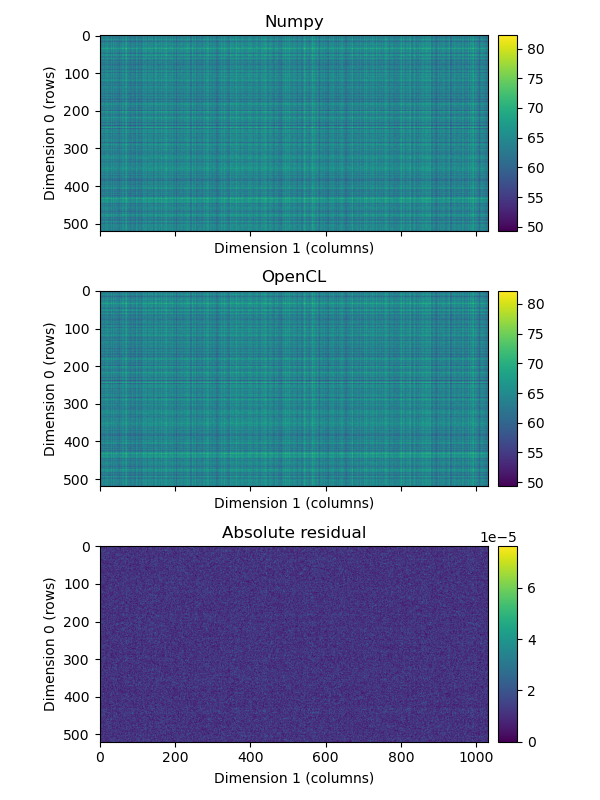

In [5]:
mat_mul.check_data()

### OpenCL 1.x atomics

OpenCL 1.x has basic support for atomic operations. Documentation is available [here](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/atomicFunctions.html) and the operations are for use within a kernel to ensure atomic operations are conducted across work items. These functions mostly operate on signed or unsigned integers that are part of the global or local address space.

In the file [atomics.cpp](atomics.cpp) is an example of OpenCL 1.x atomics in operation. We create a buffer_T that is the size of cl_uint and increment it atomically in the **atomic_test** kernel in [kernels_atomics.c](kernels_atomics.c).

```C++
// Kernel to test atomics
__kernel void atomics_test1 (__global unsigned int* T) {
    
    // Increment T atomically
    atomic_add(T, 1);
}
```


### Memory synchronisation in OpenCL 2.0+ - atomics and fences

OpenCL 1.x has a **relaxed** memory model. It means that consistency between items in a workgroup is only guaranteed at a workgroup barrier, and consistency between host and device memory is only guaranteed at synchronisation points like **clFinish** or **clWaitForEvents** or after blocking memory copies. There are basic atomic functions within OpenCL 1.x, however with the introduction of OpenCL 2.0 there needed to be more sophisticated synchronisation between host and device. OpenCL 2.0+ has two types of synchronisation constructs.

* Fences
* Atomic operations

In the code [atomics2.cpp](atomics2.cpp) is an equivalent operation to the atomics from the example above. Instead we use an atomic type **std::atomic_uint from** **\<atomic\>** as the initialised memory for **Buffer_T**. 

```C++
    // atomics2.cpp:82

    // Make an atomic counter
    std::atomic_uint value_T = { 0 };

    // Make some global memory for an atomic operation
    cl_mem buffer_T = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_COPY_HOST_PTR, 
        sizeof(std::atomic_uint), 
        &value_T, 
        &errcode
    );
    h_errchk(errcode, "Creating buffer_T");
```

Then, in the kernel in file [kernels_atomics2.c](kernels_atomics2.c) we use the OpenCL 2.0+ function **atomic_fetch_add** to increment the counter.

```C++
// kernels_atomics2.c:0

// Kernel to test OpenCL atomics v2.0
__kernel void atomics_test2 (__global atomic_uint* T) {
      
    // Increment T atomically using OpenCL 2.0
    atomic_fetch_add(T, 1);
}
```

Since this is OpenCL 2.0+ kernel code we need to include the **"-cl-std=CL2.0"** build flag in [atomics2.cpp](atomics2.cpp)

```C++
    // atomics2.cpp:102

    // Turn this source code into a program
    cl_program program = h_build_program(kernel_source, context, device, "-cl-std=CL2.0");
```

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the Pawsey Supercomputing Centre
</address>